In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from preprocess import get_concat_results, mean_aggregate_results, MODEL_ORDER

%load_ext autoreload
%autoreload 2

In [2]:
tdf, edf, ldf = get_concat_results("../results_ultimate_%d", 1, 10, {"PyTorch_compile": True}, full=False)

mtdf, medf, mldf = mean_aggregate_results(tdf, edf, ldf, train_preserve_epoch=False, 
										  train_preserve_warmup=False, latency_preserve_epoch=False)

## Klasyfikacja obrazów

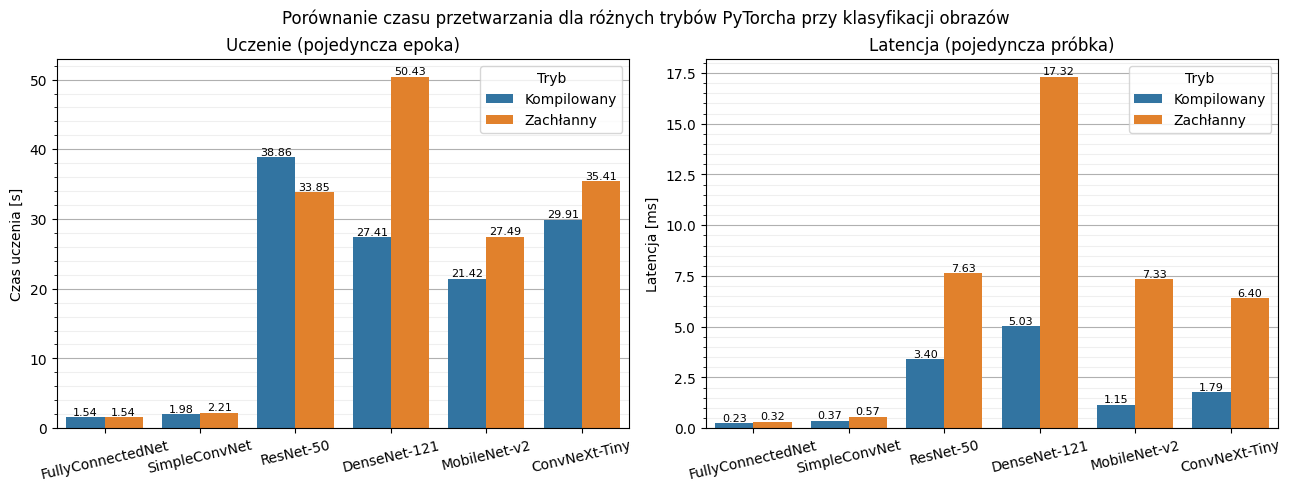

In [3]:
def clf_torch_compile_comp_plot(data: pd.DataFrame, order: list[str], ax: matplotlib.axes._axes.Axes, ylabel: str, title: str):
	data.framework = data.framework.apply(lambda v: "Zachłanny" if v == "PyTorch_eager" else "Kompilowany") 
	n_models = data.model_name.unique().shape[0]
	sns.barplot(data=data, x="model_name", y="elapsed_time_mean", hue="framework", order=order, zorder=2, ax=ax)
	ax.legend(title="Tryb")
	ax.set_xlabel("")
	ax.set_ylabel(ylabel)
	ax.set_title(title)
	ax.set_xticklabels(ax.get_xticklabels(), rotation=13)
	ax.grid(axis="y", which="major", zorder=1)
	ax.minorticks_on()
	ax.tick_params(axis='x', which='minor', bottom=False)
	ax.grid(visible=True, axis="y", which="minor", alpha=0.2, zorder=1)
	for container in ax.containers:
		ax.bar_label(container, fmt="{:.2f}", fontsize=8)


fig, axes = plt.subplots(1, 2, constrained_layout=True)
fig.set_size_inches(12.8, 4.8)
fig.suptitle("Porównanie czasu przetwarzania dla różnych trybów PyTorcha przy klasyfikacji obrazów")

mtdf_clf = mtdf[mtdf.model_name != "DCGAN"].copy()
clf_torch_compile_comp_plot(mtdf_clf, order=MODEL_ORDER[:-2], ax=axes[0], ylabel="Czas uczenia [s]", title="Uczenie (pojedyncza epoka)")

mldf_clf = mldf[(mldf.model_name != "DCGAN") & (mldf.phase == "latency")].copy()
clf_torch_compile_comp_plot(mldf_clf, order=MODEL_ORDER[:-2], ax=axes[1], ylabel="Latencja [ms]", title="Latencja (pojedyncza próbka)")

In [4]:
# dac tabelke z czasem kompilacji (x: tryb, y: model, fld: mean, std)
edf_clf = edf[(edf.phase == "graph_compilation")].copy().drop(["phase"], axis=1)
edf_clf.framework = edf_clf.framework.apply(lambda v: "Zachłanny" if v == "PyTorch_eager" else "Kompilowany")

edf_clf_grouped = edf_clf.groupby(["framework", "model_name"])
edf_clf_mean = edf_clf_grouped.mean().rename(columns={"elapsed_time": "elapsed_time_mean"})
edf_clf_std = edf_clf_grouped.std().rename(columns={"elapsed_time": "elapsed_time_std"})
edf_clf_stats = edf_clf_mean.merge(edf_clf_std, left_index=True, right_index=True).reset_index()
edf_clf_stats["elapsed_time"] = edf_clf_stats.apply(lambda row: f"{row.elapsed_time_mean:.2f} +/- {row.elapsed_time_std:.2f}", axis=1)

edf_clf_stats.pivot(index="model_name", columns="framework", values="elapsed_time")

framework,Kompilowany,Zachłanny
model_name,,
ConvNeXt-Tiny,9802.73 +/- 2950.72,11.70 +/- 2.12
DCGAN,4641.24 +/- 4400.82,3.62 +/- 5.17
DenseNet-121,32813.31 +/- 16414.32,31.31 +/- 10.95
FullyConnectedNet,1944.66 +/- 2550.01,4.63 +/- 12.41
MobileNet-v2,10463.36 +/- 3190.92,11.39 +/- 4.95
ResNet-50,10276.43 +/- 3439.00,13.79 +/- 6.56
SimpleConvNet,1565.73 +/- 793.09,6.60 +/- 17.18


## Generacja obrazów

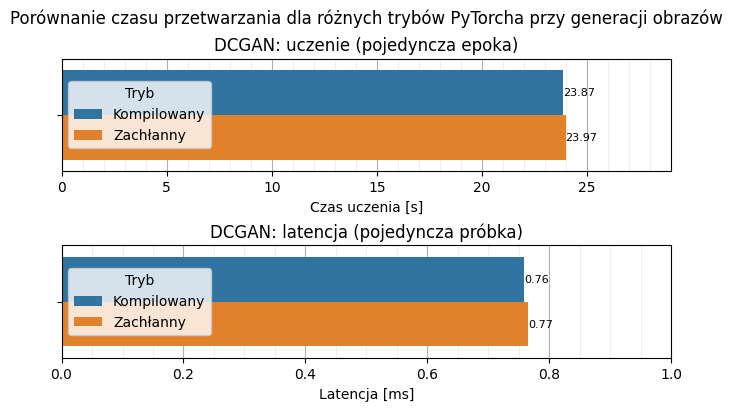

In [9]:
# jeden fig, dwa axes: uczenie i latencja, tabelka z kompilacja (x: tryb, y: mean, std)
fig, axes = plt.subplots(2, 1, constrained_layout=True)
fig.suptitle("Porównanie czasu przetwarzania dla różnych trybów PyTorcha przy generacji obrazów")
fig.set_size_inches(6.4, 4)

mtdf_dcgan = mtdf[mtdf.model_name == "DCGAN"].copy()
mtdf_dcgan.framework = mtdf_dcgan.framework.apply(lambda v: "Zachłanny" if v == "PyTorch_eager" else "Kompilowany") 
sns.barplot(data=mtdf_dcgan, y="model_name", x="elapsed_time_mean", hue="framework", zorder=2, ax=axes[0], orient="h")
axes[0].legend(title="Tryb", loc="center left")
axes[0].set_ylabel("")
axes[0].set_xlabel("Czas uczenia [s]")
axes[0].set_title("DCGAN: uczenie (pojedyncza epoka)")
axes[0].set_yticklabels(axes[0].get_yticklabels(), visible=False)
axes[0].grid(axis="x", which="major", zorder=1)
axes[0].minorticks_on()
axes[0].tick_params(axis='x', which='minor', bottom=False)
axes[0].grid(visible=True, axis="x", which="minor", alpha=0.2, zorder=1)
axes[0].set_xlim(right=29)
for container in axes[0].containers:
	axes[0].bar_label(container, fmt="{:.2f}", fontsize=8)

mldf_dcgan = mldf[(mldf.model_name == "DCGAN") & (mldf.phase == "latency")].copy()
mldf_dcgan.framework = mldf_dcgan.framework.apply(lambda v: "Zachłanny" if v == "PyTorch_eager" else "Kompilowany") 
sns.barplot(data=mldf_dcgan, y="model_name", x="elapsed_time_mean", hue="framework", zorder=2, ax=axes[1], orient="h")
axes[1].legend(title="Tryb", loc="center left")
axes[1].set_ylabel("")
axes[1].set_xlabel("Latencja [ms]")
axes[1].set_title("DCGAN: latencja (pojedyncza próbka)")
axes[1].set_yticklabels(axes[1].get_yticklabels(), visible=False)
axes[1].grid(axis="x", which="major", zorder=1)
axes[1].minorticks_on()
axes[1].tick_params(axis='x', which='minor', bottom=False)
axes[1].grid(visible=True, axis="x", which="minor", alpha=0.2, zorder=1)
axes[1].set_xlim(right=1)
for container in axes[1].containers:
	axes[1].bar_label(container, fmt="{:.2f}", fontsize=8)

In [10]:
medf_dcgan = medf[(medf.model_name == "DCGAN") & (medf.phase == "graph_compilation")].copy()
medf_dcgan

,index,framework,model_name,phase,elapsed_time_mean,elapsed_time_std
2,2,PyTorch_compile,DCGAN,graph_compilation,4641.243872,4400.821194
16,16,PyTorch_eager,DCGAN,graph_compilation,3.621613,5.171868


In [16]:
edf.reindex()[(edf.model_name == "DCGAN") & (edf.phase == "graph_compilation")]

,framework,model_name,phase,elapsed_time
24,PyTorch_eager,DCGAN,graph_compilation,0.837632
26,PyTorch_compile,DCGAN,graph_compilation,2572.054199
24,PyTorch_eager,DCGAN,graph_compilation,1.101824
26,PyTorch_compile,DCGAN,graph_compilation,2605.156494
24,PyTorch_eager,DCGAN,graph_compilation,0.746624
26,PyTorch_compile,DCGAN,graph_compilation,1981.708862
24,PyTorch_eager,DCGAN,graph_compilation,1.705856
26,PyTorch_compile,DCGAN,graph_compilation,2207.065430
24,PyTorch_eager,DCGAN,graph_compilation,6.025216
26,PyTorch_compile,DCGAN,graph_compilation,10432.923828


## Detekcja obiektów

mean:


elapsed_time
model_name framework                
YOLOv8m    Kompilowany     18.988085
           Zachłanny       37.361417

std:


elapsed_time
model_name framework                
YOLOv8m    Kompilowany      1.137860
           Zachłanny        0.977029

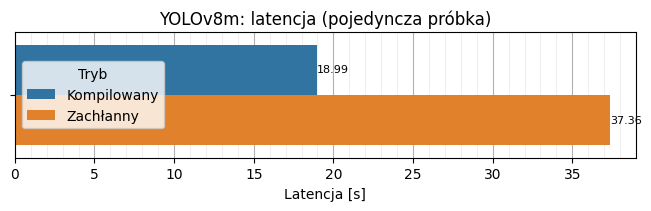

In [ ]:
# jeden ax barplot horyzontalny dla latencji, tabelka z kompilacja jak wyzej
yolo_df = pd.read_csv("../results_ultimate_0/pytorch-yolo.csv")
yolo_df.framework = yolo_df.framework.apply(lambda v: "Zachłanny" if v == "PyTorch" else "Kompilowany") 
yolo_df = yolo_df[yolo_df.phase == "latency"].copy()
yolo_df = yolo_df.drop(["phase", "loss", "performance", "epoch"], axis=1)
yolo_df_grouped = yolo_df.groupby(["model_name", "framework"])

print("mean:")
display(mydf := yolo_df_grouped.mean())
print("std:")
display(yolo_df_grouped.std())

yolo_df = yolo_df_grouped.mean().reset_index()

fig, ax = plt.subplots(1, 1, constrained_layout=True)
fig.set_size_inches(6.4, 2)
sns.barplot(data=yolo_df, y="model_name", x="elapsed_time", hue="framework", zorder=2, ax=ax, orient="h")
ax.legend(title="Tryb", loc="center left")
ax.set_ylabel("")
ax.set_xlabel("Latencja [s]")
ax.set_title("YOLOv8m: latencja (pojedyncza próbka)")
ax.set_yticklabels(ax.get_yticklabels(), visible=False)
ax.grid(axis="x", which="major", zorder=1)
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=False)
ax.grid(visible=True, axis="x", which="minor", alpha=0.2, zorder=1)
ax.set_xlim(right=39)
for container in ax.containers:
	ax.bar_label(container, fmt="{:.2f}", fontsize=8)

In [ ]:
# czas kompilacji
yolo_df = pd.read_csv("../results_ultimate_0/pytorch-yolo.csv")
yolo_df.framework = yolo_df.framework.apply(lambda v: "Zachłanny" if v == "PyTorch" else "Kompilowany") 
yolo_df_comp = yolo_df[yolo_df.phase == "graph_compilation"].copy().drop(["model_name", "phase", "loss", "elapsed_time", "epoch"], axis=1)
yolo_df_comp_grouped = yolo_df_comp.groupby(["framework"])

print("mean:")
display(yolo_df_comp_grouped.mean())

print("std:")
display(yolo_df_comp_grouped.std())

mean:


,performance
framework,
Kompilowany,381.889463
Zachłanny,388.686741


std:


,performance
framework,
Kompilowany,72.976418
Zachłanny,77.730035


### Average advantage of `torch.compile`

In [ ]:
eager_mtdf = mtdf[mtdf.framework == "PyTorch_eager"].set_index("model_name").drop(["index", "framework", "elapsed_time_std"], axis=1)
compile_mtdf = mtdf[mtdf.framework == "PyTorch_compile"].set_index("model_name").drop(["index", "framework", "elapsed_time_std"], axis=1)
mtdf_comp = eager_mtdf.merge(compile_mtdf, left_index=True, right_index=True, suffixes=("_eager", "_compile"))

mtdf_comp["faster_time"] = mtdf_comp.elapsed_time_mean_eager - mtdf_comp.elapsed_time_mean_compile
mtdf_comp["faster_ratio"] = mtdf_comp.elapsed_time_mean_eager / mtdf_comp.elapsed_time_mean_compile
mtdf_comp["faster_percent"] = mtdf_comp.faster_time / mtdf_comp.elapsed_time_mean_eager * 100
print("Training advantage:")
display(mtdf_comp)

eager_mldf = mldf[(mldf.framework == "PyTorch_eager") & (mldf.phase == "latency")].set_index("model_name").drop(["index", "framework", "elapsed_time_std", "phase"], axis=1)
compile_mldf = mldf[(mldf.framework == "PyTorch_compile") & (mldf.phase == "latency")].set_index("model_name").drop(["index", "framework", "elapsed_time_std", "phase"], axis=1)
mldf_comp = eager_mldf.merge(compile_mldf, left_index=True, right_index=True, suffixes=("_eager", "_compile"))

mldf_comp["faster_time"] = mldf_comp.elapsed_time_mean_eager - mldf_comp.elapsed_time_mean_compile
mldf_comp["faster_ratio"] = mldf_comp.elapsed_time_mean_eager / mldf_comp.elapsed_time_mean_compile
mldf_comp["faster_percent"] = mldf_comp.faster_time / mldf_comp.elapsed_time_mean_eager * 100
print("Inference advantage:")
display(mldf_comp)

Training advantage:


,elapsed_time_mean_eager,elapsed_time_mean_compile,faster_time,faster_ratio,faster_percent
model_name,,,,,
ConvNeXt-Tiny,36.022929,30.201441,5.821488,1.192755,16.160506
DCGAN,23.740692,23.630189,0.110503,1.004676,0.465460
DenseNet-121,51.540612,28.604466,22.936146,1.801838,44.501114
FullyConnectedNet,1.539309,1.551593,-0.012284,0.992083,-0.798013
MobileNet-v2,28.249078,22.140490,6.108588,1.275901,21.624027
ResNet-50,34.240750,38.849516,-4.608766,0.881369,-13.459885
SimpleConvNet,2.230098,1.977551,0.252547,1.127707,11.324486


Inference advantage:


,elapsed_time_mean_eager,elapsed_time_mean_compile,faster_time,faster_ratio,faster_percent
model_name,,,,,
ConvNeXt-Tiny,6.781424,1.832745,4.948679,3.700145,72.974036
DCGAN,0.753298,0.734831,0.018467,1.025131,2.451502
DenseNet-121,17.341581,4.894029,12.447552,3.543416,71.778644
FullyConnectedNet,0.232437,0.230149,0.002288,1.009941,0.984353
MobileNet-v2,6.782560,1.094399,5.688161,6.197520,83.864514
ResNet-50,6.939049,3.365950,3.573099,2.061542,51.492628
SimpleConvNet,0.600767,0.382295,0.218472,1.571477,36.365580


In [ ]:
yolo_lat_compile = mydf.iloc[0].elapsed_time
yolo_lat_eager = mydf.iloc[1].elapsed_time

print("YOLOv8m inference advantage:")
print(f"Time saved: {yolo_lat_eager - yolo_lat_compile}")
print(f"Ratio: {yolo_lat_eager / yolo_lat_compile}")
print(f"Percent faster: {(yolo_lat_eager - yolo_lat_compile) / yolo_lat_eager * 100}")

YOLOv8m inference advantage:
Time saved: 18.37333173751831
Ratio: 1.9676242508114627
Percent faster: 49.17728831673056
